In [1]:
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import itertools
# Sklearn imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import datasets
from nltk.corpus import stopwords
from nltk import bigrams
import nltk
import seaborn as sn
from collections import Counter, defaultdict
from gensim.sklearn_api.w2vmodel import W2VTransformer
from gensim.sklearn_api.d2vmodel import D2VTransformer
from itertools import chain
from decimal import Decimal
from IPython.display import display, HTML
from ast import literal_eval
import xlrd
import operator
import math
import openpyxl

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
def row(key, scores, params):
            d = {
                 'estimator': key,
                 'mean_score': np.mean(scores),
                 'f1-scores': scores,
            }
            return pd.Series({**params,**d})
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stemmer = nltk.stem.snowball.SnowballStemmer("dutch")

In [3]:
# Importing data
df = pd.read_csv("Handelingen.csv", index_col=0)
df = df.loc[df['speech category'] == 'Main Speech']

df['list_text'] = df.text.apply(lambda x: [stemmer.stem(t) for t in tokenizer.tokenize(x)])
df['normal_text'] = df.list_text.apply(lambda x: ' '.join(x))
df.head(5)

,surname,party,text,file,speech category,date,tags,list_text,normal_text
107136,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']","[mevrouw, de, voorzitter, dit, kabinet, heeft,...",mevrouw de voorzitter dit kabinet heeft ons mo...
107137,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']","[voorzitter, vorig, wek, plaatst, werkgever, w...",voorzitter vorig wek plaatst werkgever werknem...
107138,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']","[voorzitter, twee, maand, geled, kreg, dit, ka...",voorzitter twee maand geled kreg dit kabinet v...
107139,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']","[voorzitter, allen, al, in, de, eerst, drie, m...",voorzitter allen al in de eerst drie maand van...
107148,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']","[voorzitter, we, zijn, eruit, eerst, ontdekt, ...",voorzitter we zijn eruit eerst ontdekt de mini...


# Data Info

In [18]:
# Creates a dataframe with counts of dataset per party
countdf = df.party.value_counts().sort_index()
with open("Verslag/Tables/Spreekbeurten.tex", "w") as f:
    f.write(countdf.to_latex(header=False))
countdf

50PLUS           413
CDA             2216
ChristenUnie    1223
D66             2211
GroenLinks      1193
PVV             1880
PvdA            2269
PvdD             480
SGP              770
SP              2573
VVD             2157
Name: party, dtype: int64

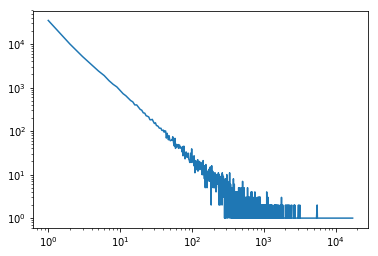

In [5]:
tekst = chain.from_iterable([list(set(doc)) for doc in df.list_text])
count = Counter(tekst)
samples = list(count.values())
t = Counter(samples)
t = sorted(t.items())
x, y = zip(*t)
plt.loglog(x, y)
plt.show()

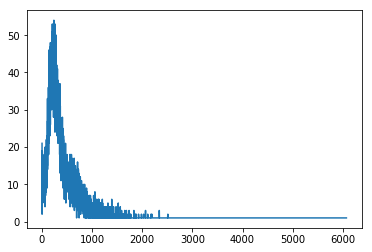

In [6]:
t = Counter([len(doc) for doc in df.list_text])
t = sorted(t.items())
x, y = zip(*t)
plt.plot(x, y)
plt.show()

# Mutual Info

In [7]:
#testtesttest = df.list_text.apply(lambda x: x + list(bigrams(x)))
text_dict = {x: y for x, y in zip(df.index, df.list_text)}
class_dict = defaultdict(list)

for x,y in zip(df.party, df.index):
    class_dict[x].append(y)
    
enddoc = defaultdict(lambda : defaultdict(int))
totaldocs = 0
lijst = []
setnormalized = {doc: list(set(words)) for doc, words in text_dict.items()}
for c, dlist in class_dict.items():
    totaldocs += len(dlist)
    for doc in dlist:
        for word in setnormalized[doc]:
            enddoc[word][c] += 1
            enddoc[word]["total"] += 1
            
def MU(word, c, enddoc, class_dict, totaldocs):
    N = totaldocs
    N11 = enddoc[word][c]
    N01 = len(class_dict[c]) - N11
    N10 = enddoc[word]["total"] - N11
    N00 = N - N11 - N01 - N10
    N21 = N11 + N01
    N12 = N10 + N11
    N02 = N01 + N00
    N20 = N10 + N00
    return ((N11 / N) * float(Decimal((N * N11) / (N12 * N21)).log10()) / math.log(2, 10) 
        + (N01 / N) * float(Decimal((N * N01) / (N02 * N21)).log10()) / math.log(2, 10) 
        + (N10 / N) * float(Decimal((N * N10) / (N12 * N20)).log10()) / math.log(2, 10) 
        + (N00 / N) * float(Decimal((N * N00) / (N02 * N20)).log10()) / math.log(2, 10))
enddoc = {c: {word : MU(word, c, enddoc, class_dict, totaldocs) for word in enddoc.keys()} 
          for c in class_dict.keys()}
mudf = pd.DataFrame.from_dict(enddoc)

In [8]:
# Dit kan simpeler
terms10 = {c: mudf[c].nlargest(10).to_dict() for c in class_dict}
terms10x = {x:[p for p,q in sorted(y.items(), key=operator.itemgetter(1), reverse = True)] for x,y in terms10.items()}
MIdf = pd.DataFrame(terms10x)
MIdf

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,50plus,cda,christenunie,d66,groenlink,pvv,pvda,dier,sgp,sp,vvd
1,krol,omtzigt,faber,veldhov,tonger,islamitisch,arbeid,ouwehand,mevrouw,gerv,reger
2,gepensioneerd,keijzer,dik,mijn,voortman,belangrijk,partij,thiem,staaij,leijt,lid
3,plusser,geurt,voordewind,fractie,klaver,immigratie,vvd,bio,bewindslied,dank,nr
4,ouder,pvv,schout,pia,grashoff,graf,pvv,industrie,punt,jasper,krijgt
5,aow,agnes,seger,sjoerdsma,ojik,graus,albert,dierenwelzijn,beantwoord,cda,blijkt
6,pensioen,mulder,vvd,bergkamp,schon,tony,cda,milieu,dank,lid,verzoekt
7,koopkrachtontwikkel,antwoord,overweg,buitengewon,overweg,klever,lid,veehouderij,je,reger,beraadslag
8,ouderenwerklos,vvd,sp,dijkstra,groenlinksfractie,fritsma,zegt,landbouw,allerlei,bashir,ondersteund
9,koopkracht,helvert,schepping,vandag,cda,madlener,d66,biodiversiteit,even,smaling,ervan


In [9]:
with open("Verslag/Tables/MItable.tex", "w") as f:
    f.write(MIdf.iloc[:,:5].to_latex(index=False))
with open("Verslag/Tables/MItable2.tex", "w") as f:
    f.write(MIdf.iloc[:,5:].to_latex(index=False))

# Models

In [10]:
def modelsdownload(only_doen=False):
    models_df = pd.read_excel('Models.xlsx', index_col=0)
    if only_doen:
        models_df = models_df.loc[models_df.DOEN == True]
    models_dict = {}
    for x,y in zip(models_df.Classifier, models_df.PIPELINE):
        exec(compile("a="+y,'','exec'), globals())
        models_dict[x] = Pipeline(a)
    return models_df, models_dict

In [11]:
models_df, models_dict = modelsdownload(True)

# Creates a dict with parameters per classifier   
params_dict = {}
for clf in set(models_df.Classifier):
    params_df = models_df.loc[models_df.Classifier == clf]
    params_df = params_df.loc[params_df.DOEN == True]
    params_df = params_df.dropna(axis=1, how='all')
    params_df = params_df.drop([col for col in params_df.columns if "__" not in col], axis=1)
    temp_dict = {}
    for x, y in params_df.to_dict(orient='list').items():
        a = literal_eval(y[0])
        temp_dict[x] = a   
    params_dict[clf] = temp_dict
    
text_dict = {x:y for x,y in zip(models_df.Classifier, models_df.RAW)}

In [12]:
for name,pipe in models_dict.items():
    
    if text_dict[name]:
         text = list(df.list_text)
    else:
        text = list(df.normal_text)
        
    gs = GridSearchCV(pipe, params_dict[name], cv=5, scoring='f1_weighted')
    gs.fit(text, df.party)
    rows = [row(name, gsc.cv_validation_scores, gsc.parameters) for gsc in gs.grid_scores_]
    df2 = pd.concat(rows, axis=1).T
    pd.concat([df2, pd.read_csv('Scores.csv', index_col=0)], ignore_index=True).sort_values(['mean_score'], ascending=False).to_csv('Scores.csv')
    df4 = pd.read_excel('Models.xlsx', index_col=0)
    df4.loc[df.Classifier==name,"DOEN"] = False
    df4.to_excel('Models.xlsx')
    
#https://stackoverflow.com/questions/46735847/save-best-params-in-gridsearch-in-a-pandas-dataframe
# https://stackoverflow.com/questions/36271413/pandas-merge-nearly-duplicate-rows-based-on-column-value?rq=1

# Best Score

In [13]:
# Select the classifier and parameters with highest score
scores = pd.read_csv('Scores.csv', index_col=0).head(1)
scores = scores.dropna(axis=1).reset_index(drop=True)
scores.vect__ngram_range[0] = literal_eval(scores.vect__ngram_range[0])
models_df, models_dict = modelsdownload(False)
pipe = models_dict[scores.estimator[0]]
pipe.set_params(**scores.drop([col for col in scores.columns if "__" not in col], axis=1).to_dict(orient='records')[0])

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.99999999, max_features=None, min_df=0.001,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=...cnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))])

In [14]:
df_train = df.sample(frac=0.8)
df_test_index = list(set(df.index.tolist()) - set(df_train.index.tolist()))
df_test = df[df.index.isin(df_test_index)]
pipe.fit(list(df_train.normal_text), list(df_train.party))
predicted = pipe.predict(df_test.normal_text)
print(classification_report(df_test.party, predicted))

              precision    recall  f1-score   support

      50PLUS       0.88      0.88      0.88        78
         CDA       0.73      0.75      0.74       431
ChristenUnie       0.81      0.70      0.75       234
         D66       0.72      0.69      0.70       447
  GroenLinks       0.81      0.69      0.74       263
         PVV       0.75      0.80      0.77       359
        PvdA       0.67      0.65      0.66       473
        PvdD       0.78      0.83      0.81        70
         SGP       0.80      0.74      0.77       168
          SP       0.72      0.78      0.75       522
         VVD       0.67      0.73      0.70       432

 avg / total       0.73      0.73      0.73      3477



In [15]:
#source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

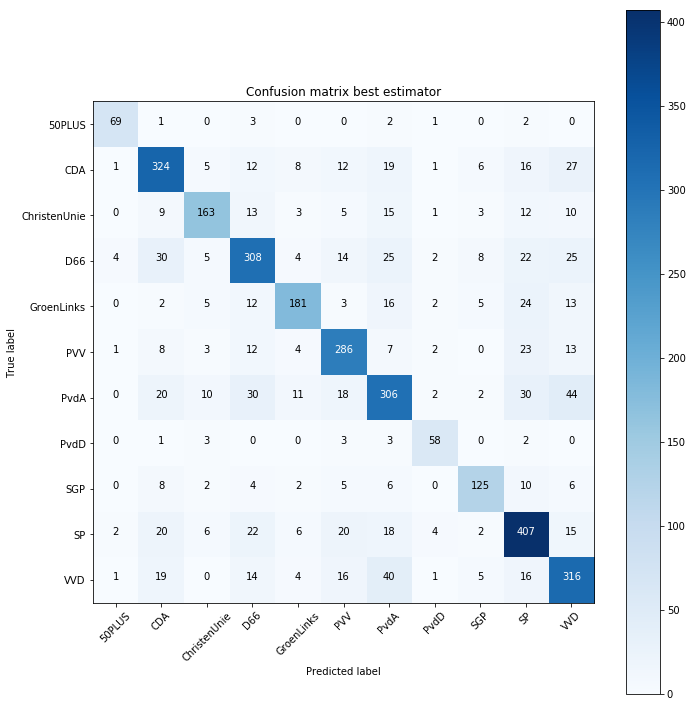

In [16]:
plt.figure(figsize=(10, 10))
cnf_matrix = confusion_matrix(df_test.party, predicted)
plot_confusion_matrix(cnf_matrix, \
                      classes=sorted(list(df.party.unique())), \
                      title='Confusion matrix best estimator')
plt.savefig("Verslag/confusionmatrix.png")
plt.show()

# Git

In [17]:
!git pull
!git add CompleteNotebook.ipynb
!git add Scraper.ipynb
!git add Scores.csv
!git add Verslag/Scriptie_Sprekers_TK.pdf
!git add Verslag/Tables/Spreekbeurten.tex
!git add Verslag/Tables/MItable.tex
!git add Verslag/Tables/MItable2.tex
!git add Models.xlsx
!git add Verslag/confusionmatrix.png
!git commit -m Update
!git push

Already up to date.


The file will have its original line endings in your working directory.


[master 1627778] Update
 2 files changed, 147 insertions(+), 261 deletions(-)
 rewrite Verslag/confusionmatrix.png (99%)


To https://github.com/jaspervdh96/Scriptie-Sprekers-TK.git
   e2f869a..1627778  master -> master
